In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack
from scipy import signal
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from skimage import data

plt.gray()
%matplotlib inline

In [21]:
im = data.camera().astype(np.float32) / 255

In [79]:
fs = 31
ker = np.ones((fs, fs)) / fs**2
sker = np.ones(fs) / fs

In [80]:
blur_im.shape

(481, 481)

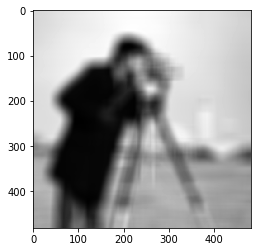

In [81]:
# Compute by convolution, circular boundaries
tmp = signal.convolve2d(im, sker[None], mode='valid')
blur_im = signal.convolve(tmp, sker[:, None], mode='valid')
# blur_im = ndimage.convolve(tmp, ker, mode='wrap')
plt.imshow(blur_im)

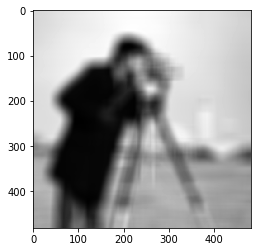

In [86]:
# FFT Convolve
pad_ker = np.zeros_like(im, dtype=np.float32)
si = 0
fudge_factor = 2*(fs-1)
pad_ker[si:si+ker.shape[0], si:si+ker.shape[1]] = ker
fft_ker = np.fft.rfft2(np.pad(pad_ker, ((0, fudge_factor), (0, fudge_factor)), 'constant'))
fft_im = np.fft.rfft2(np.pad(im, fudge_factor//2, 'constant'))
fft_conv_res = np.fft.irfft2(fft_ker * fft_im)[fudge_factor: -fudge_factor//2, fudge_factor:-fudge_factor//2]
assert (np.abs(fft_conv_res.imag) < 1e-5).all()
fft_conv_res = fft_conv_res.real
plt.imshow(fft_conv_res)

In [87]:
((fft_conv_res - blur_im)**2).sum()

1.4382965930706679e-10